In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Projet de APM_52068

In [2]:
# Données
nu = 3.15
D2 = 0.8
D3 = 0.5

## 3. Résolution bayésienne

### Question 1

Il suffit de montrer que $\widetilde{\mathcal{L}}\bigl(\overrightarrow{y}\mid x\bigr) \approx \mathcal{L}\bigl(\overrightarrow{y}\mid x\bigr)$.

On a $$ 
\begin{aligned}
\mathcal{L}\bigl(\overrightarrow{y}\mid x\bigr) & \approx \prod_{k=1}^{N} \exp\left(-\frac{1}{2}\left(y_k - f(x)\right)^T C_{obs}^{-1} \left(y_k - f(x)\right)\right) \\
& = \exp\left(-\frac{1}{2}\sum_{k=1}^{N}\left(y_k - f(x)\right)^T C_{obs}^{-1} \left(y_k - f(x)\right)\right) \\
& = \exp\left(-\frac{N}{2} \frac{1}{N}\sum_{k=1}^{N}\left(y_k - \overline{y} + \overline{y} - f(x)\right)^T C_{obs}^{-1} \left(y_k - \overline{y} + \overline{y}- f(x)\right)\right) \\
& = \exp\left(-\frac{N}{2} \left(\frac{1}{N}\sum_{k=1}^{N}\left(y_k - \overline{y}\right)^T C_{obs}^{-1} \left(y_k - \overline{y}\right) + \frac{1}{N}\sum_{k=1}^{N}\left(\overline{y} - f(x)\right)^T C_{obs}^{-1} \left(\overline{y} - f(x)\right) + \frac{2}{N}\sum_{k=1}^{N}\left( y_k - \overline{y}\right)^T C_{obs}^{-1} \left(\overline{y} - f(x)\right) \right)\right) \\
& = \exp\left(-\frac{N}{2} \left(\frac{1}{N}\sum_{k=1}^{N}\left(y_k - \overline{y}\right)^T C_{obs}^{-1} \left(y_k - \overline{y}\right) + \left(\overline{y} - f(x)\right)^T C_{obs}^{-1} \left(\overline{y} - f(x)\right) \right)\right) \\
& \approx \exp\left(-\frac{N}{2} \left(\left(\overline{y} - f(x)\right)^T C_{obs}^{-1} \left(\overline{y} - f(x)\right) \right)\right) \\
& = \widetilde{\mathcal{L}}\bigl(\overrightarrow{y}\mid x\bigr)
\end{aligned} $$

Donc $$p(x) \approx p_{prior}(x)\widetilde{\mathcal{L}}\bigl(\overrightarrow{y}\mid x\bigr) $$

### Question 2

On écrit d'abord une fonction qui renvoie $f(x)$ :

Temps : 0 sec

In [5]:
def f(x):
    '''
    Modèle utilisé, supposé lourd
    '''
    res = np.zeros(x.shape)
    rho = (x[0]-1)*x[0]
    res[0] = - (x[1]*x[2])/(rho*nu)
    res[1] = x[1]*D2/rho**2
    res[2] = 3*res[1]**2 - x[1]**2*D3/rho**3
    return res

On écrit maintenant qui renvoie des mesures bruitées $(y_k)_{1 \leq k\leq N}$ sous forme d'une matrice de taille $N \times 3$ :

Temps : 0 sec

In [6]:
def mesures_bruit(x,N,C):
    '''
    Mesures par le modèle, bruitées selon un bruit gaussien de covariance C
    '''
    F = f(x)
    bruits = np.random.multivariate_normal(np.zeros(3),cov = C,size = N)
    return F + bruits

x_t = np.array([0.8,0.03,140000]) # Valeur vraie au point de mesure
N = 5
C_obs = np.array([[10**4, 7, 2.5],
                  [7, 10**(-2), 4*10**(-3)],
                  [2.5, 4*10**(-3), 2.5*10**(-3)]])

Y = mesures_bruit(x_t,N,C_obs)
print(Y)

[[8.36672965e+03 9.67239738e-01 2.71887321e+00]
 [8.42092186e+03 1.03069293e+00 2.79965266e+00]
 [8.23125751e+03 9.20947912e-01 2.72775489e+00]
 [8.09408454e+03 6.88251013e-01 2.64782241e+00]
 [8.32715721e+03 1.02879552e+00 2.82264937e+00]]


### Question 3

Pour échantilloner la loi a posteriori, on utilise un algorithme de Metropolis-Hasting adaptatif, utilisant une loi d'exploration gaussienne. Ainsi, en lien avec la question précédente, on pose la log-vraissemblance conditionnelle :
$$ \Phi(u;y) = \frac{N}{2} \left(\left(\overline{y} - f(u)\right)^T C_{obs}^{-1} \left(\overline{y} - f(u)\right) \right), $$

ainsi que la probabilité d'acceptation :
$$a(u,v)= \text{min}\left\{ 1, \text{exp}\left(\Phi(u;y) - \Phi(v;y)\right) \right\}. $$

L'aspect adaptatif de l'algorithme consiste à ajuster la matrice de covariance de la loi d'exploration en cours d'échantillonage. Pour cela, toute les $\verb|adapt_interval|$ intérations, on remplace cette matrice de covariance par la matrice de covariance empirique issue des $\verb|adapt_interval|$ dernières données, à un facteur multiplicatif près. L'intérêt de cette manipulation est de mieux de contrôler le taux d'acceptation lors de l'échantillonage, pour le maintenir autour de 20%.

Temps : 0 sec

In [7]:
Cov_explo = 0.3 * np.diag([0.95-0.6, 5e-2 - 5e-3, 2e5 - 8e4]) # Matrice de covariance de la loi d'exploration
alpha = 0.30 # Paramètre d'actualisation de la loi d'exploration

def in_domain(u):
    '''
    Retourne True si u est dans le domaine de X
    '''
    return (
        0.6 <= u[0] <= 0.95 and
        5.0e-3 <= u[1] <= 5.0e-2 and
        8.0e4 <= u[2] <= 2.0e5
    )

def Phi(u,Y_):
    '''
    Log-vraisemblance de u conditionnellement à Y_
    '''
    mean_y = np.mean(Y_,axis = 0)
    diff = mean_y - f(u)
    quad = diff @ np.linalg.inv(C_obs) @ diff
    return N/2 * quad

def acceptation(u,v,Y_):
    '''
    Probabilité d'acceptation de la proposition v à partir de u
    '''
    return np.min([1,np.exp(Phi(u,Y_) - Phi(v,Y_))])


def metropolis_hastings(u0,N_echantillon,burn_in,Y_):
    '''
    Algorithme de Metropolis-Hastings
    '''
    u = u0 # Initialisation
    v_list = [] # Liste des échantillons

    accepte = 0 # Compteur d'acceptation

    adapt = Cov_explo
    adapt_interval = 1000 # Intervalle d'actualisation de la loi d'exploration

    for i in range(N_echantillon + burn_in):
        v = np.random.multivariate_normal(u,alpha*adapt) # Proposition
        while not in_domain(v): 
            v = np.random.multivariate_normal(u,alpha*adapt) # On rejette les propositions hors du domaine
        v_list.append(v) # On ajoute la proposition à la liste

        if np.random.rand() < acceptation(u,v,Y_): # Acceptation
            u = v
            accepte += 1
        if i % adapt_interval == 0 and i > 0: # Actualisation de la loi d'exploration
            data = np.array(v_list[i - adapt_interval: i])
            if data.shape[0] >1:
                cov = np.cov(data, rowvar=False) # Covariance empirique
                adapt = cov + 1e-8 * np.eye(3) # On ajoute un terme de régularisation
            
    taux_acceptation = accepte/(N_echantillon + burn_in)

    return np.array(v_list[burn_in:]), taux_acceptation


Temps : 7 sec

In [8]:
N_echantillon = 100000
burn_in = 10000

u0 = np.array([0.65,0.02,160000])
M_echantillon, taux_acceptation = metropolis_hastings(u0,N_echantillon,burn_in,Y)
print(taux_acceptation)

/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_4511/2787492830.py:27: RuntimeWarning: overflow encountered in exp
  return np.min([1,np.exp(Phi(u,Y_) - Phi(v,Y_))])


0.22847272727272727


Le taux d'acceptation est d'environ 20% ce qui est un bon taux d'acceptation. On peut désormais afficher la distribution échantillonée, ainsi que l'évolution des variables simulées.

Temps : 1 sec

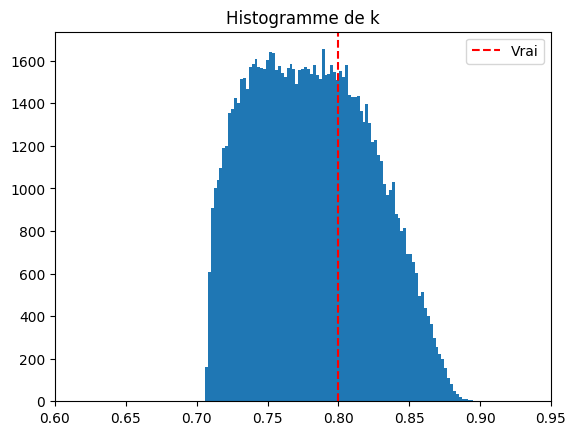

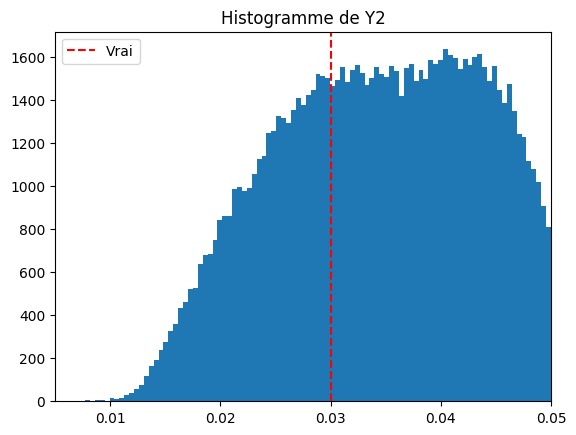

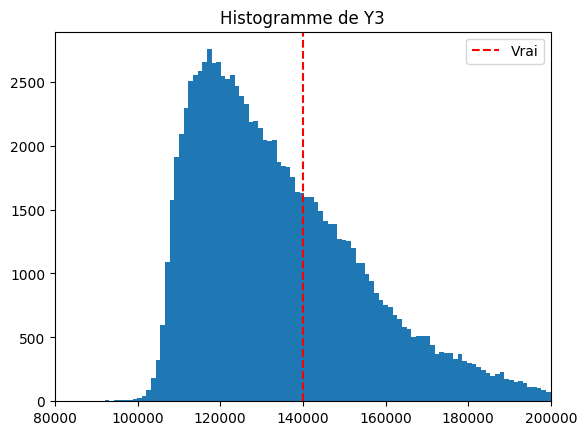

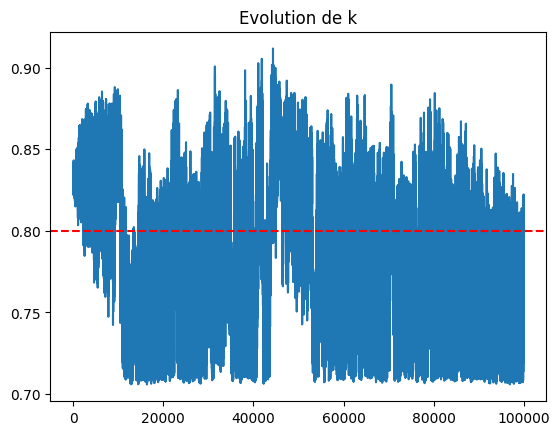

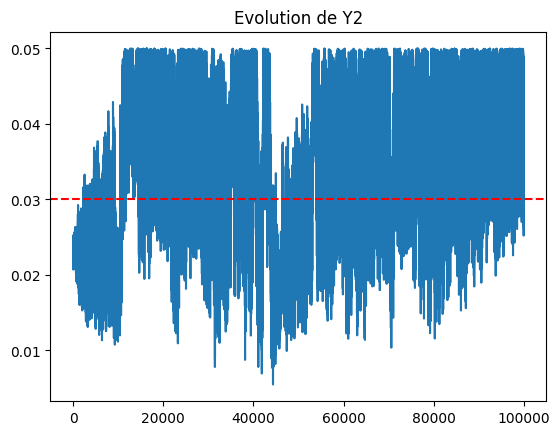

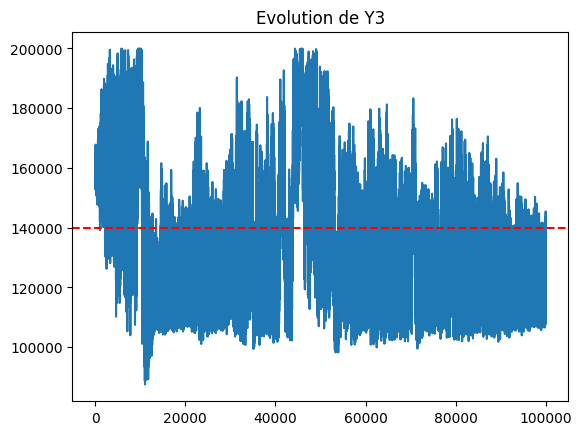

In [9]:
# Distribution de k
plt.hist(M_echantillon[:,0],bins = 100)
plt.title("Histogramme de k")
plt.axvline(x_t[0], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de k
plt.xlim(0.6, 0.95)
plt.legend()
plt.show()

# Distribution de Y2
plt.hist(M_echantillon[:,1],bins = 100)
plt.title("Histogramme de Y2")
plt.axvline(x_t[1], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de Y2
plt.xlim(5e-3, 5e-2)
plt.legend()
plt.show()

# Distribution de Y3
plt.hist(M_echantillon[:,2],bins = 100)
plt.title("Histogramme de Y3")
plt.axvline(x_t[2], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de Y3
plt.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.xlim(8e4, 2e5)
plt.legend()
plt.show()


# Evolution de k
plt.plot(M_echantillon[:,0])
plt.title("Evolution de k")
plt.axhline(x_t[0], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de k
plt.show()

# Evolution de Y2
plt.plot(M_echantillon[:,1])
plt.title("Evolution de Y2")
plt.axhline(x_t[1], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de Y2
plt.show()

# Evolution de Y3
plt.plot(M_echantillon[:,2])
plt.title("Evolution de Y3")
plt.axhline(x_t[2], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de Y3
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()


## 4. Résolution bayésienne avec métamodèle

### Question 4

On construit un plan d'expérience de type hypercube latin maximin couvrant le pavé $\chi$.

Pour cela, on va tirer $s = 500$ hypercubes latins et on va choisir celui qui maximise la distance minimale entre les points : $$ \text{min}\left\{ \left\|x_i - x_j\right\|_2, i\neq j \right\} $$

Temps : 15 sec

In [10]:
M = 200
s = 500

def hypercube_latin(M):
    '''
    Génère un échantillon de taille M selon la méthode de l'hypercube latin
    '''
    # Dimension 3 donc on génère 3 permutations aléatoires
    sigma_1 = np.random.permutation(M)
    sigma_2 = np.random.permutation(M)
    sigma_3 = np.random.permutation(M)
    U = np.random.rand(M,3) # On génère un M variables uniforme sur [0,1]^3
    X = np.zeros((M,3))
    for i in range(M): 
        X[i,0] = 0.6  + (0.95-0.6) * (sigma_1[i] + U[i,0])/M
        X[i,1] = 5e-3 + (5e-2-5e-3) * (sigma_2[i] + U[i,1])/M
        X[i,2] = 8e4 + (2e5 - 8e4) * (sigma_3[i] + U[i,2])/M
    return X

def min_distance(X):
    '''
    Retourne la distance minimale entre les points de X
    '''
    min_dist = np.inf
    for i in range(M):
        for j in range(i+1,M):
            dist = np.linalg.norm(X[i] - X[j])
            if dist < min_dist:
                min_dist = dist
    return min_dist 

hypercube_latin_maximin = None
min_dist = 0

# On génère s échantillons et on garde celui avec la distance minimale maximale
for k in range(s):
    X = hypercube_latin(M)
    dist = min_distance(X)
    if dist > min_dist:
        hypercube_latin_maximin = X
        min_dist = dist


Temps : 0 sec

In [11]:
print(hypercube_latin_maximin)

[[9.02867736e-01 3.20712007e-02 1.20650782e+05]
 [6.58197684e-01 3.66480217e-02 1.65393765e+05]
 [6.21645830e-01 1.31914626e-02 1.62829760e+05]
 [6.75424742e-01 2.04641529e-02 1.84025972e+05]
 [7.74823418e-01 3.82059821e-02 1.26561161e+05]
 [8.81726812e-01 2.57590528e-02 1.16303287e+05]
 [7.95049540e-01 1.05562504e-02 1.99078464e+05]
 [6.84557113e-01 3.97832653e-02 1.70484050e+05]
 [8.11510090e-01 3.58792966e-02 1.53120480e+05]
 [8.03167222e-01 1.56915761e-02 9.72598759e+04]
 [8.94408409e-01 7.58215233e-03 8.07045235e+04]
 [7.10949973e-01 2.07146297e-02 1.82413772e+05]
 [7.89153786e-01 2.07555810e-02 1.47674561e+05]
 [8.67453426e-01 1.98525195e-02 1.18547154e+05]
 [6.13549198e-01 6.78367042e-03 1.68142861e+05]
 [8.93441433e-01 1.96303364e-02 1.50087168e+05]
 [9.09239827e-01 2.77499848e-02 9.44453822e+04]
 [7.97061681e-01 2.80179642e-02 1.76707961e+05]
 [7.64461319e-01 3.51797954e-02 1.37782329e+05]
 [7.87272678e-01 3.76386140e-02 1.82698910e+05]
 [7.67014292e-01 4.47843044e-02 1.509061

On construit les mesures bruitées $Y$.

Temps : 0 sec

In [12]:
Y_hyper = np.zeros((M,3))

for i in range(M):
    Y_hyper[i] = mesures_bruit(hypercube_latin_maximin[i],1,C_obs)

Pour $R$, on prend un métamodèle gaussien à $p=4$ paramètres : 
\begin{equation*}
\begin{split}
R_{\rm meta}(x) &= \beta_1^R + \beta_2^R x_1 +\beta_3^R x_2 + \beta_4^R x_3 +Z_{\rm R}(\bm{x})
 \\
 & = \mu_{\rm R}(\bm{x}) + Z_{\rm R}(\bm{x})
\end{split}
\end{equation*}
où $Z_{\rm R}(\bm{x})$ est un processus stationnaire gaussien de moyenne nulle et de fonction de covariance $c(\bm{x,\tilde{x}}) = C_{\rm R}(x-\tilde{x}) =\sigma_{\rm R}^2 \exp \Big( - \frac{(x-\tilde{x})^2}{l_{c,R}^2} \Big)$

On fait de même pour $Y_2$ et $Y_3$.

On veut d'abord estimer des valeurs raisonnables pour les hyper-paramètres du modèle. Pour cela, nous utilisons la méthode du maximum de vraissemblance. 

Ainsi , 
$$
(\hat{l}_{c,R},\hat{\sigma}_R) = \underset{l_{\rm R},\sigma_R}{\mathrm{argmin}}\left\{(y_{obs} −y_0)^TW_{{\rm R}, yy}(l_{\rm R},\sigma_R)(y_{obs} −y_0)+\rm{ln}\left(\rm{det}(R(l_{\rm R},\sigma_R))\right)\right\},
$$

où $$W(l_{\rm R},\sigma_R) = R^{−1}(l_{\rm R}) − R^{−1}(l_{\rm R})H\left(H^T R^{−1}(l_{\rm R})H\right)^{−1}H^T R^{−1}(l_{\rm R})$$
et $$R(l_{\rm R},\sigma_R) = \left(\sigma^2\exp \Big( - \frac{(x^{(i)}-x^{(j)})^2}{l_{c,R}^2} \Big) + \sigma_{mes}^2 1(i=j) \right)_{i,j}$$





Temps : 0 sec

In [13]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve

H = np.concatenate([np.ones((M, 1)), hypercube_latin_maximin], axis=1)

# Définition des fonctions
def C_0(a, b, l_c_R=0.1):
    '''
    Facteur exponentiel de la fonction de covariance
    '''
    return np.exp(-np.linalg.norm(a - b) ** 2 / l_c_R ** 2)

def R_R1(l_c_R=0.1, sigma=1): 
    '''
    Matrice de covariance R_R
    '''
    R_R = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            R_R[i, j] = sigma**2 * C_0(hypercube_latin_maximin[i], hypercube_latin_maximin[j], l_c_R)
    R_R += np.eye(M) * 1e4 
    return R_R

def L_R(params):
    '''
    (opposé de la) Log-vraisemblance de R, fonction à minimiser
    '''
    l_c, sigma = params
    R_R = R_R1(l_c, sigma)

    try:
        # Décomposition de Cholesky pour une meilleure stabilité numérique
        L_chol = cho_factor(R_R, lower=True)
        R_inv_H = cho_solve(L_chol, H)

        # Calcul de W sans inversion explicite
        W = cho_solve(L_chol, np.eye(M)) - R_inv_H @ np.linalg.inv(H.T @ R_inv_H) @ R_inv_H.T

        # Calcul du log-déterminant de R_R de manière stable
        sign, logdet = np.linalg.slogdet(R_R)
        if sign <= 0:  # Matrice mal conditionnée
            return np.inf

        return Y_hyper[:, 0].T @ W @ Y_hyper[:, 0] + logdet

    except np.linalg.LinAlgError:  # Capture les erreurs d'inversion de matrice
        return np.inf



Temps : 15 sec

In [14]:
# Optimisation de L(l_c, sigma)
initial_guess = [0.5, 3500]  # Valeurs initiales
bounds = [(1e-3, 10), (1e-3, 1e8)]  # Contraintes

# Minimisation de L
result = minimize(L_R, initial_guess, method="L-BFGS-B", bounds=bounds)

# Résultats optimaux
l_c_opt_R, sigma_opt_R = result.x
print(f"Optimal l_c: {l_c_opt_R}, Optimal sigma: {sigma_opt_R}")

# Vérification du succès
if result.success:
    print("Optimisation réussie!")
else:
    print(f"Échec de l'optimisation : {result.message}")

Optimal l_c: 0.5, Optimal sigma: 2770.922926239847
Optimisation réussie!


Temps : 0 sec

In [15]:
def R_Y2(l_c_Y2=0.1, sigma=1): 
    R = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            R[i, j] = sigma**2 * C_0(hypercube_latin_maximin[i], hypercube_latin_maximin[j], l_c_Y2)
    R += np.eye(M) * 1e-2
    return R

def L_Y2(params):
    l_c, sigma = params
    R = R_Y2(l_c, sigma)

    try:
        # Décomposition de Cholesky pour une meilleure stabilité numérique
        L_chol = cho_factor(R, lower=True)
        R_inv_H = cho_solve(L_chol, H)

        # Calcul de W sans inversion explicite
        W = cho_solve(L_chol, np.eye(M)) - R_inv_H @ np.linalg.inv(H.T @ R_inv_H) @ R_inv_H.T

        # Calcul du log-déterminant de R_R de manière stable
        sign, logdet = np.linalg.slogdet(R)
        if sign <= 0:  # Matrice mal conditionnée
            return np.inf

        return Y_hyper[:, 1].T @ W @ Y_hyper[:, 1] + logdet

    except np.linalg.LinAlgError:  # Capture les erreurs d'inversion de matrice
        return np.inf

Temps : 7 sec

In [16]:
# Optimisation de L(l_c, sigma)
initial_guess = [0.5, 1.2]  # Valeurs initiales
bounds = [(1e-3, 10), (1e-3, 1e7)]  # Contraintes

# Minimisation de L
result = minimize(L_Y2, initial_guess, method="L-BFGS-B", bounds=bounds)

# Résultats optimaux
l_c_opt_Y2, sigma_opt_Y2 = result.x
print(f"Optimal l_c: {l_c_opt_Y2}, Optimal sigma: {sigma_opt_Y2}")

# Vérification du succès
if result.success:
    print("Optimisation réussie!")
else:
    print(f"Échec de l'optimisation : {result.message}")

Optimal l_c: 0.5, Optimal sigma: 1.096884347452214
Optimisation réussie!


Temps : 0 sec

In [17]:
def R_Y3(l_c_Y2=0.1, sigma=1): 
    R = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            R[i, j] = sigma**2 * C_0(hypercube_latin_maximin[i], hypercube_latin_maximin[j], l_c_Y2)
    R += np.eye(M) * 2.5e-3
    return R

def L_Y3(params):
    l_c, sigma = params
    R = R_Y3(l_c, sigma)

    try:
        # Décomposition de Cholesky pour une meilleure stabilité numérique
        L_chol = cho_factor(R, lower=True)
        R_inv_H = cho_solve(L_chol, H)

        # Calcul de W sans inversion explicite
        W = cho_solve(L_chol, np.eye(M)) - R_inv_H @ np.linalg.inv(H.T @ R_inv_H) @ R_inv_H.T

        # Calcul du log-déterminant de R_R de manière stable
        sign, logdet = np.linalg.slogdet(R)
        if sign <= 0:  # Matrice mal conditionnée
            return np.inf

        return Y_hyper[:, 2].T @ W @ Y_hyper[:, 2] + logdet

    except np.linalg.LinAlgError:  # Capture les erreurs d'inversion de matrice
        return np.inf

Temps : 5 sec

In [18]:
# Optimisation de L(l_c, sigma)
initial_guess = [0.5, 50]  # Valeurs initiales
bounds = [(1e-3, 10), (1e-3, 1e7)]  # Contraintes

# Minimisation de L
result = minimize(L_Y3, initial_guess, method="L-BFGS-B", bounds=bounds)

# Résultats optimaux
l_c_opt_Y3, sigma_opt_Y3 = result.x
print(f"Optimal l_c: {l_c_opt_Y3}, Optimal sigma: {sigma_opt_Y3}")

# Vérification du succès
if result.success:
    print("Optimisation réussie!")
else:
    print(f"Échec de l'optimisation : {result.message}")

Optimal l_c: 0.5, Optimal sigma: 30.46889244463319
Optimisation réussie!


On utilise désormais les hyper-paramètres estimés pour construire des processus gaussiens modélisants $f$, à partir des formules du cours. Ici, on ne suppose pas de distribution à priori sur les paramètres $\beta$.

Temps : 0 sec

In [19]:
# Tenseur de susceptibilité
H = np.vstack([np.ones(M),hypercube_latin_maximin.T]).T

# Hyperparamètres optimaux
sigma_R = sigma_opt_R
l_c_R = l_c_opt_R

def C_R(a,b) :
    '''
    Fonction de covariance du processus gaussien
    '''
    diff = a - b
    dist2 = np.sum(diff**2,axis=-1)
    return sigma_R**2*np.exp(-dist2/l_c_R**2)


R_R = np.zeros((M,M))

for i in range(M):
    for j in range(M):
        # On ajoute l'incertitude de mesure sur la diagonale pour obtenir la matrice de covariance
        R_R[i,j] = C_R(hypercube_latin_maximin[i],hypercube_latin_maximin[j]) + 1e4 * (i==j)


Q_post_R = np.linalg.inv(H.T@np.linalg.inv(R_R) @ H)
beta_post_R = Q_post_R @ H.T @ np.linalg.inv(R_R) @ Y_hyper[:,0] # Paramètres du métamodèle

print("Les paramètres sont pour R:",beta_post_R)

# L'observation en un point x0 est désormais une variable aléatoire gaussienne
# On peut calculer sa moyenne et sa variance conditionnellement aux observations précédentes
# grâce aux paramètres du métamodèle
solution_R = np.linalg.solve(R_R,Y_hyper[:,0] - H @ beta_post_R)
def R_post(x0):
    '''
    Moyenne de l'observation en x0 conditionnellement aux observations précédentes
    '''
    h0 = np.concatenate(([1], x0))
    res = h0.T @ beta_post_R
    
    r0 = C_R(x0,hypercube_latin_maximin)
    
    res += r0.T @ solution_R
    return res

def R_post_var(x0):
    '''
    Variance de l'observation en x0 conditionnellement aux observations précédentes
    '''
    h0 = np.concatenate(([1], x0))
    r0 = C_R(x0,hypercube_latin_maximin)

    H_ = np.zeros(M+4)
    H_[:4] = h0
    H_[4:] = r0

    zero = np.zeros((4,4))
    M_ = np.block([
        [zero, H.T],
        [H, R_R]
    ])

    return C_R(0,0) + 1e4 - H_.T @ np.linalg.inv(M_) @ H_


Les paramètres sont pour R: [-3.24228474e+04  3.30593958e+04  2.82028575e+05  5.42206684e-02]


Temps : 0 sec

In [20]:
sigma_Y2 = sigma_opt_Y2
l_c_Y2 = l_c_opt_Y2

def C_Y2(a,b) :
    diff = a - b
    dist2 = np.sum(diff**2, axis=-1)
    return sigma_Y2**2*np.exp(-dist2/l_c_Y2**2)


R_Y2 = np.zeros((M,M))

for i in range(M):
    for j in range(M):
        R_Y2[i,j] = C_Y2(hypercube_latin_maximin[i],hypercube_latin_maximin[j]) + 1e-2 * (i==j)

Q_post_Y2 = np.linalg.inv(H.T@np.linalg.inv(R_Y2) @ H)
beta_post_Y2 = Q_post_Y2 @ H.T @ np.linalg.inv(R_Y2) @ Y_hyper[:,1]

print("Les paramètres sont pour Y2:",beta_post_Y2)

solution_Y2 = np.linalg.solve(R_Y2, Y_hyper[:,1] - H @ beta_post_Y2)

def Y2_post(x0):
    h0 = np.concatenate(([1], x0))
    res = h0.T @ beta_post_Y2
    
    r0 = C_Y2(x0,hypercube_latin_maximin)
    
    res += r0.T @ solution_Y2
    return res

r0_var_Y2 = np.array([C_Y2(0, hypercube_latin_maximin[i]) for i in range(M)])

def Y2_post_var(x0):
    h0 = np.concatenate(([1], x0))
    r0 = C_Y2(x0,hypercube_latin_maximin)

    H_ = np.zeros(M+4)
    H_[:4] = h0
    H_[4:] = r0

    zero = np.zeros((4,4))
    M_ = np.block([
        [zero, H.T],
        [H, R_Y2]
    ])

    return C_Y2(0,0) + 1e-2 - H_.T @ np.linalg.inv(M_) @ H_

Les paramètres sont pour Y2: [-8.00599030e+00  1.10038731e+01  4.11132839e+01 -2.14181236e-06]


Temps : 0 sec

In [21]:
sigma_Y3 = sigma_opt_Y3
l_c_Y3 = l_c_opt_Y3

def C_Y3(a,B) :
    diff = B - a  
    dist2 = np.sum(diff**2, axis=-1)
    return sigma_Y3**2 * np.exp(-dist2 / l_c_Y3**2)

R_Y3 = np.zeros((M,M))

for i in range(M):
    for j in range(M):
        R_Y3[i,j] = C_Y3(hypercube_latin_maximin[i],hypercube_latin_maximin[j]) + 2.5e-3 * (i==j)

Q_post_Y3 = np.linalg.inv(H.T@np.linalg.inv(R_Y3) @ H)
beta_post_Y3 = Q_post_Y3 @ H.T @ np.linalg.inv(R_Y3) @ Y_hyper[:,2]

print("Les paramètres sont pour Y3:",beta_post_Y3)

solution_Y3 = np.linalg.solve(R_Y3, Y_hyper[:,2] - H @ beta_post_Y3)

def Y3_post(x0):
    h0 = np.concatenate(([1], x0))
    res = h0.T @ beta_post_Y3
    
    r0 = np.array([C_Y3(x0, hypercube_latin_maximin[i]) for i in range(M)])
    
    res += r0.T @ solution_Y3
    return res

def Y3_post_var(x0):
    h0 = np.concatenate(([1], x0))
    r0 = np.array([C_Y3(x0,hypercube_latin_maximin[i]) for i in range(M)])

    H_ = np.zeros(M+4)
    H_[:4] = h0
    H_[4:] = r0

    zero = np.zeros((4,4))
    M_ = np.block([
        [zero, H.T],
        [H, R_Y3]
    ])

    return C_Y3(0,0) + 2.5e-3 - H_.T @ np.linalg.inv(M_) @ H_

Les paramètres sont pour Y3: [-1.36616854e+02  1.85498412e+02  6.09675897e+02 -7.13249543e-05]


On teste les fonctions avec une base de test de 200 points tirés aléatoirement dans $\chi$.

Du métamodèle construit à partir des observations précédentes (entrainement), on obtient que l'observation en un point de test est une variable aléatoire gaussienne, dont la moyenne et la variance ont été calculées dans les cellules précédentes. Cette loi a posteriori des obsevations nous permet de construire facilement un intervale de confiance à 95%.

Ainsi, pour vérifier le métamodèle que l'on a construit, on peut réaliser une véritable observation sur les 200 points de tests (à l'aide de la fonction mesures_bruit), et compter combien de ces véritables observations tombent dans l'intervale de confiance prédit par le métamodèle. 

Temps : 0 sec

Temps : 0 sec

In [22]:
# On génère un échantillon de 200 points dans le domaine de X
N_test = 200

U = np.random.rand(N_test,3)
X_test = np.zeros((N_test,3))
for i in range(N_test):
    X_test[i,0] = 0.6  + (0.95-0.6) * U[i,0]
    X_test[i,1] = 5e-3 + (5e-2-5e-3) * U[i,1]
    X_test[i,2] = 8e4 + (2e5 - 8e4) * U[i,2]

# On réalise des mesures (bruités) en ces points.
Y_test = np.zeros((N_test,3))
for i in range(N_test):
    Y_test[i]= f(X_test[i]) + np.random.multivariate_normal(np.zeros(3),cov = C_obs)
print(Y_test)

[[ 7.97824818e+03  6.03747694e-01  9.41063777e-01]
 [ 9.52205844e+03  6.36973599e-01  1.23799498e+00]
 [ 1.53122062e+04  3.84971012e+00  4.60109861e+01]
 [ 9.63359468e+03  1.95930247e+00  1.10536999e+01]
 [ 8.78349291e+03  6.03667934e-01  9.55446069e-01]
 [ 1.71903935e+03  2.04309729e-01  1.87126351e-01]
 [ 2.02359513e+04  2.88674634e+00  2.72645048e+01]
 [ 8.30347676e+03  4.79405799e-01  9.23633228e-01]
 [ 1.53365749e+04  2.02269808e+00  1.26173052e+01]
 [ 2.65034462e+03  3.51867319e-01  3.61698561e-01]
 [ 2.77576215e+04  4.74718976e+00  7.44472446e+01]
 [ 2.18244877e+03  1.04494994e-01  1.30965807e-01]
 [ 2.64017140e+03  2.29375527e-01  2.10486479e-01]
 [ 5.16547182e+03  2.63416024e-01  2.29536903e-01]
 [ 4.11118600e+03  2.22241725e-01  1.99059147e-01]
 [ 6.46010542e+03  2.95087793e+00  2.66423887e+01]
 [ 9.57573514e+03  4.59880918e-01  9.13948560e-01]
 [ 1.65140230e+04  1.56848564e+00  9.67184243e+00]
 [ 8.25586883e+03  1.03382796e+00  3.25162513e+00]
 [ 4.31693123e+03  3.52204989e-

Temps : 5 sec

In [23]:
# On prédit les valeurs de R, Y2 et Y3 en ces points à l'aide du métamodèle
# On prend la moyenne de la loi des observations selon ce métamodèle
R_pred = np.array([R_post(X_test[i]) for i in range(N_test)])
Y2_pred = np.array([Y2_post(X_test[i]) for i in range(N_test)])
Y3_pred = np.array([Y3_post(X_test[i]) for i in range(N_test)])

dans_intevalle_R = 0
dans_intevalle_Y2 = 0
dans_intevalle_Y3 = 0
dans_intevalle_total = 0

for i in range(N_test):
    # On vérifie si la mesure est dans l'intervalle de confiance à 95% prédit par le métamodèle
    est_dans_interv = True
    if R_pred[i] - 1.96*np.sqrt(R_post_var(X_test[i])) <= Y_test[i,0] <= R_pred[i] + 1.96*np.sqrt(R_post_var(X[i])):
        dans_intevalle_R += 1
    else:
        est_dans_interv = False
    if Y2_pred[i] - 1.96*np.sqrt(Y2_post_var(X_test[i])) <= Y_test[i,1] <= Y2_pred[i] + 1.96*np.sqrt(Y2_post_var(X[i])):
        dans_intevalle_Y2 += 1
    else:    
        est_dans_interv = False
    if Y3_pred[i] - 1.96*np.sqrt(Y3_post_var(X_test[i])) <= Y_test[i,2] <= Y3_pred[i] + 1.96*np.sqrt(Y3_post_var(X[i])):
        dans_intevalle_Y3 += 1
    else:    
        est_dans_interv = False
    if est_dans_interv: dans_intevalle_total += 1

print(f"Mesures dans l'intervale de R : {100*dans_intevalle_R/N_test}%")
print(f"Mesures dans l'intervale de Y2 : {100*dans_intevalle_Y2/N_test}%")
print(f"Mesures dans l'intervale de Y3 : {100*dans_intevalle_Y3/N_test}%")
print(f"Mesures dans l'intervale total : {100*dans_intevalle_total/N_test}%")


Mesures dans l'intervale de R : 95.0%
Mesures dans l'intervale de Y2 : 95.0%
Mesures dans l'intervale de Y3 : 95.5%
Mesures dans l'intervale total : 94.0%


Les fréquences obtenues correspondent au niveau de confiance des intervales, ce qui nous permet de ne pas rejeter notre métamodèle.

### Question 5
On commence par remarquer que $C_{\mathrm{tot}}(x)$ peut s'écrire sous forme simplifiée à l'aide du produit de Kronecker :
$$
C_{\mathrm{tot}}(x)
\;=\;
\bigl(I_N \otimes C_{\mathrm{obs}}\bigr)\;+\;\bigl(\mathbf{1}_N\mathbf{1}_N^\mathsf{T}\otimes C(x,x)\bigr)
$$
où $\mathbf{1}_N$ est un vecteur de taille $N$ rempli de $1$.

On rappelle une propriété utile du produit de Kronecker :\
Pour toute matrice $A, B, C$ et $D$, de tailles compatibles, 
$$\left(A\otimes B\right)\left(C\otimes D\right) = AB\otimes CD$$

Montrons que
$$\rm{det}(C_{\mathrm{tot}}(x)) = N^3 \, \rm{det}\left(C_{obs}\right)^{N-1} \, \rm{det}\left(C(x,x) + \frac{1}{N}C_{obs}\right).$$

Pour cela, prenons $\lambda$ une valeur propre de $N\,C(x,x) + C_{obs}$, et $\bm{X}$ un vecteur propre associé :
$$ 
\begin{aligned}
C_{\mathrm{tot}}(x)\left(\mathbf{1}_N \otimes \bm{X} \right) &= (I_N\mathbf{1}_N) \otimes (C_{obs}X) + \left(\mathbf{1}_N\mathbf{1}_N^\mathsf{T}\mathbf{1}_N\right) \otimes \left(C(x,x)X\right) \\
&= \mathbf{1}_N \otimes (C_{obs}X) + N\mathbf{1}_N \otimes \left(C(x,x)X\right) \\
&= \mathbf{1}_N \otimes \left[\left(C_{obs} + N\,C(x,x)\right)X\right] \\
&= \lambda \mathbf{1}_N \otimes X
\end{aligned}
$$

Donc $\lambda$ est aussi valeur propre de $C_{\mathrm{tot}}(x)$ de la même multiplicité que celle en tont que voleur propre de $N\,C(x,x) + C_{obs}$.
Donc toutes les valeurs propres de $N\,C(x,x) + C_{obs}$ sont des valeurs propres de $C_{\mathrm{tot}}(x)$.

On a donc trouvé 3 valeurs propres (eventuellement identiques) de $C_{\mathrm{tot}}(x)$. Il reste à en trouver $3(N-1)$.

Prenons $\lambda$ une valeur propre de $C_{obs}$, et $\bm{X}$ un vecteur propre associé. On pose :
$$
\begin{aligned}
\mathcal{E} &= \left\{V \in \R^N / \mathbf{1}_N^\mathsf{T}V = 0 \right\} \\
&= \rm{Vect}(\mathbf{1}_N)^{\bot} 
\end{aligned}
$$

Directement, on a que $\rm{dim}\, \mathcal{E} = N - 1$, et pour $V \in \mathcal{E}$ :
$$ 
\begin{aligned}
C_{\mathrm{tot}}(x)\left(V \otimes \bm{X} \right) &= (I_NV) \otimes (C_{obs}X) + \left(\mathbf{1}_N\mathbf{1}_N^\mathsf{T}V\right) \otimes \left(C(x,x)X\right) \\
&= V \otimes (C_{obs}X) + 0 \otimes \left(C(x,x)X\right) \\
&= \lambda V \otimes X
\end{aligned}
$$

Donc $\lambda$ est aussi valeur propre de $C_{\mathrm{tot}}(x)$. Comme on a pris $V \in \mathcal{E}$ arbitraire, la multiplicité de $\lambda$ en tant que valeur propre $C_{\mathrm{tot}}(x)$ est multipliée par $N-1$ par rapport à sa multiplicité en tant que valeur propre de $C_{obs}$.

On a donc trouvé les $3(N-1)$ autres valeurs propres (eventuellement identiques) de $C_{\mathrm{tot}}(x)$.

Puisque le déterminant est le produit des valeurs propres, on a finalement que :
$$
\begin{aligned}
\rm{det}(C_{\mathrm{tot}}(x)) &= \rm{det}\left(C_{obs}\right)^{N-1} \, \rm{det}\left(N\, C(x,x) + C_{obs}\right) \\
&= N^3 \, \rm{det}\left(C_{obs}\right)^{N-1} \, \rm{det}\left(C(x,x) + \frac{1}{N}C_{obs}\right)
\end{aligned}
$$


Remarquons que l'on peut décomposer $\R^{3N}$ en 2 espaces orthogonaux. On pose pour cela :
$$ A = \left\{ \mathbf{1}_N \otimes X / X \in \R^3 \right\}$$
$$ B = \left\{ V \otimes X / V \in \rm{Vect}(\mathbf{1}_N)^{\bot} , X \in \R^3 \right\}$$
Et alors, $\R^{3N} = A + B$, avec $A\, \bot\, B$.

On peut s'intéresser à la forme que prend $C_{\mathrm{tot}}(x)$ sur $A$ et $B$. \
Soit $Y = \mathbf{1}_N \otimes X \in A$ :
$$C_{\mathrm{tot}}(x) Y = \mathbf{1}_N \otimes \left[\left(C_{obs} + N\,C(x,x)\right)X\right].$$
Soit $Y = V \otimes X \in B$ :
$$C_{\mathrm{tot}}(x) Y = \mathbf{1}_N \otimes \left(C_{obs}X\right).$$

Alors, dans $A$, $C_{\mathrm{tot}}(x) = I_N \otimes \left(C_{obs} + N\,C(x,x)\right)$, donc $C_{\mathrm{tot}}(x)^{-1} = I_N \otimes \left(C_{obs} + N\,C(x,x)\right)^{-1}$. 

Et dans $B$, $C_{\mathrm{tot}}(x) = I_N \otimes C_{obs}$, donc $C_{\mathrm{tot}}(x)^{-1} = I_N \otimes C_{obs}^{-1}$.

Maintenant, on pose $Z = \begin{pmatrix} z_1 \\ \vdots \\ z_N \end{pmatrix} = \begin{pmatrix} y_1 - \mu(x) \\ \vdots \\ y_N - \mu(x) \end{pmatrix}$. Remarquons que, en notant $\bar{z} = \sum_{i=1}^N z_i = \bar{y} - \mu(x)$ :
$$Z = \begin{pmatrix} \bar{z} \\ \vdots \\ \bar{z} \end{pmatrix} + \left(Z - \begin{pmatrix} \bar{z} \\ \vdots \\ \bar{z} \end{pmatrix}\right) = T + U, $$
où $T = \begin{pmatrix} \bar{z} \\ \vdots \\ \bar{z} \end{pmatrix} \in A$ et $U = Z - \begin{pmatrix} \bar{z} \\ \vdots \\ \bar{z} \end{pmatrix} \in B$ ($U$ ne dépend pas de $x$). En effet, pour tout $X \in \R^3$ :
$$\left(\mathbf{1}_N \otimes X\right)^\mathsf{T}U = \sum_{i=1}^N X^\mathsf{T}z_i - NX^\mathsf{T}\bar{z} = 0,$$
ce qui montre que $U \in B$.

Ainsi, en appliquant cette décomposition à $C_{\mathrm{tot}}(x)$ selon la disjonction de forme établie précédement :
$$
\begin{aligned}
Z^\mathsf{T}C_{\mathrm{tot}}(x)Z &= \left(T+U\right)^\mathsf{T}C_{\mathrm{tot}}(x)\left(T+U\right) \\
&= T^\mathsf{T}C_{\mathrm{tot}}(x)T + U^\mathsf{T}C_{\mathrm{tot}}(x)U \\
&= T^\mathsf{T}\begin{pmatrix} \left(C_{obs} + N\,C(x,x)\right)^{-1}\bar{z} \\ \vdots \\ \left(C_{obs} + N\,C(x,x)\right)^{-1}\bar{z} \end{pmatrix} + U^\mathsf{T}\left(I_N \otimes C_{obs}^{-1}\right)U
\end{aligned}
$$
en utilisant le fait que $A\, \bot \, B$ et que $A$ et $B$ sont stable par $C_{\mathrm{tot}}(x)$.

Le dernier terme du membre de droite ne dépend pas de $x$ car $U$ ne dépend pas de $x$. Donc finalement,
$$
\begin{aligned}
Z^\mathsf{T}C_{\mathrm{tot}}(x)Z &= N \left[\bar{z}^\mathsf{T} \left(C_{obs} + N\,C(x,x)\right)^{-1}\bar{z}\right] + \alpha \\
&= \left(\bar{y} - \mu(x)\right)^\mathsf{T}\left(C_{obs} + N\,C(x,x)\right)^{-1}\left(\bar{y} - \mu(x)\right) + \alpha.
\end{aligned}
$$
où $\alpha$ est constante en $x$.

Il suffit alors de remarquer que $Z^\mathsf{T}C_{\mathrm{tot}}(x)Z$ correspond au terme dans l'exponentielle de $\mathcal{L}(y|x)$ (à un facteur $-\frac{1}{2}$ près) pour conclure la preuve.

### Question 6

On utilise le même algorithme quand dans la question 3, en prenant la vraissemblance conditionnelle établie à la question précédente.

On prend alors comme probabilité d'acceptation :
$$a(u,v)= \text{min}\left\{ 1, \frac{\tilde{\mathcal{L}}(\vec{\mathbf{y}} \mid \mathbf{v})}{\tilde{\mathcal{L}}(\vec{\mathbf{y}} \mid \mathbf{u})} \right\} $$

Temps : 0 sec

In [24]:
alpha = 0.3
def mu(x):
    '''
    Moyenne du processus gaussien utilisé en tant que métamodèle de f
    '''
    return np.array([R_post(x),Y2_post(x),Y3_post(x)])

C_0 = np.diag([sigma_opt_R**2,sigma_opt_R**2,sigma_opt_R**2]) + 1/N * C_obs

def L_tilde(x,Y_):
    '''
    Vraisemblance de x conditionnellement à Y_
    '''
    mean_y = np.mean(Y_,axis = 0)
    diff = mean_y - mu(x)
    inv_C0_diff = np.linalg.solve(C_0,diff)
    
    return np.exp(-1/2 * diff.T @ inv_C0_diff)

def metropolis_hastings(u0,N_echantillon,burn_in,Y_):
    u = u0
    L_tilde_u = L_tilde(u,Y_)
    v_list = []

    accepte = 0

    adapt = Cov_explo
    adapt_interval = 1000

    for i in range(N_echantillon + burn_in):
        #if i % 10000 == 0:
        #    print(i)
        v = np.random.multivariate_normal(u,alpha*adapt)

        while not in_domain(v):
            v = np.random.multivariate_normal(u,alpha*adapt)
        v_list.append(v)

        acceptation = np.min([1,L_tilde(v,Y_)/L_tilde_u])

        if np.random.rand() < acceptation:
            u = v
            L_tilde_u = L_tilde(v,Y_)
            accepte += 1

        if i % adapt_interval == 0 and i > 0:
            data = np.array(v_list[i - adapt_interval: i])
            if data.shape[0] >1:
                cov = np.cov(data, rowvar=False)
                adapt = cov + 1e-6 * np.eye(3)
            
    taux_acceptation = accepte/(N_echantillon + burn_in)

    return np.array(v_list[burn_in:]), taux_acceptation

Temps : 2 min

In [25]:
N_echantillon = 100000
burn_in = 10000

u0 = np.array([0.65,0.02,160000])
M_echantillon, taux_acceptation = metropolis_hastings(u0,N_echantillon,burn_in,Y)
print(taux_acceptation)

/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_4511/3333468132.py:33: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  v = np.random.multivariate_normal(u,alpha*adapt)
/var/folders/24/f9mpl0gx1rs5tb1xb_z_cqmw0000gn/T/ipykernel_4511/3333468132.py:36: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  v = np.random.multivariate_normal(u,alpha*adapt)


0.8517454545454546


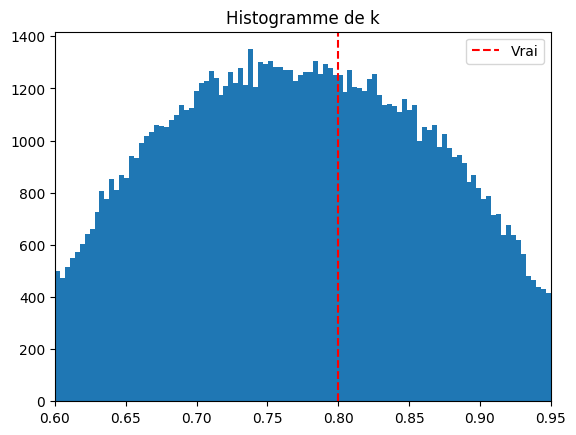

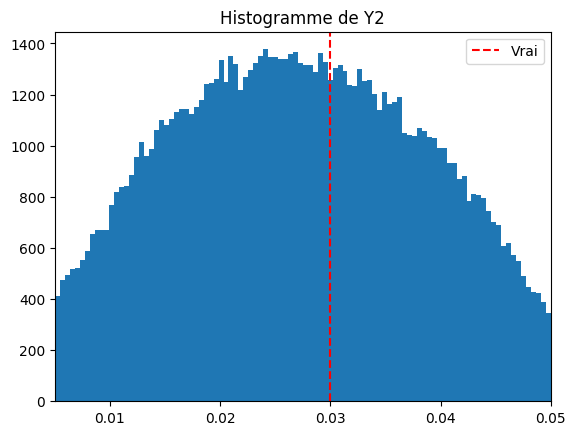

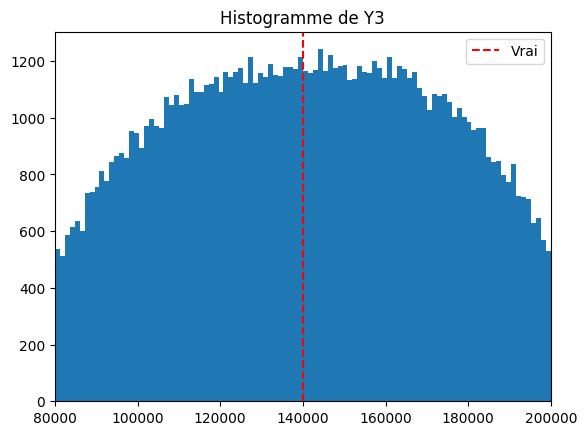

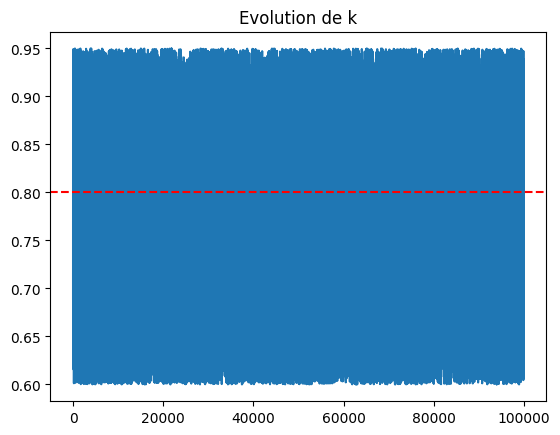

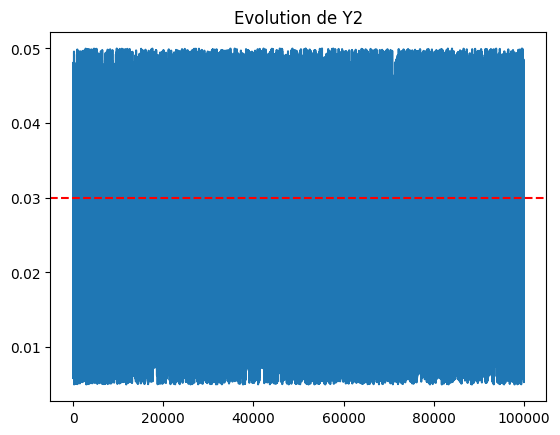

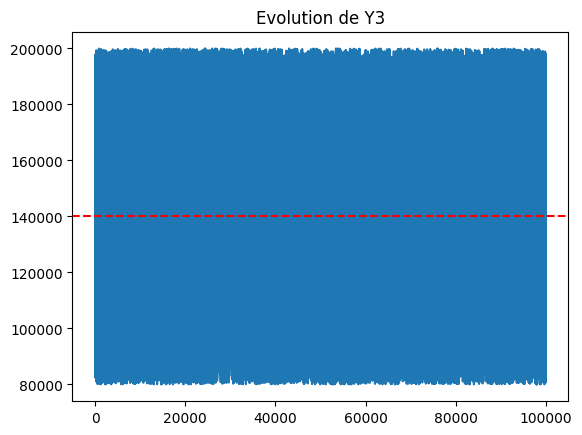

In [26]:
# Distribution de k
plt.hist(M_echantillon[:,0],bins = 100)
plt.title("Histogramme de k")
plt.axvline(x_t[0], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de k
plt.xlim(0.6, 0.95)
plt.legend()
plt.show()

# Distribution de Y2
plt.hist(M_echantillon[:,1],bins = 100)
plt.title("Histogramme de Y2")
plt.axvline(x_t[1], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de Y2
plt.xlim(5e-3, 5e-2)
plt.legend()
plt.show()

# Distribution de Y3
plt.hist(M_echantillon[:,2],bins = 100)
plt.title("Histogramme de Y3")
plt.axvline(x_t[2], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de Y3
plt.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.xlim(8e4, 2e5)
plt.legend()
plt.show()


# Evolution de k
plt.plot(M_echantillon[:,0])
plt.title("Evolution de k")
plt.axhline(x_t[0], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de k
plt.show()

# Evolution de Y2
plt.plot(M_echantillon[:,1])
plt.title("Evolution de Y2")
plt.axhline(x_t[1], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de Y2
plt.show()

# Evolution de Y3
plt.plot(M_echantillon[:,2])
plt.title("Evolution de Y3")
plt.axhline(x_t[2], color='r', linestyle='dashed', label='Vrai') # Vraie valeur de Y3
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()
